# Practice: Dealing with Word Embeddings
_Reference: embeddings visualization is based on the notebook by [YSDA NLP course](https://github.com/yandexdataschool/nlp_course)_

Today we gonna play with word embeddings: train our own little embedding, load one from `gensim` model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of Quora questions dataset.

In [1]:
!pip install -Uqq umap-learn

## Getting the data

In [2]:
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw
!wget -nc -q "https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1" -O quora.txt

In [3]:
data = list(open("quora.txt"))
data[287191]

'Why do we ask questions in Quora, when we know that we get lot of search results in Google;) No offense :) :)\n'

## Tokenization

A typical first step for an NLP task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple `str.split` won't do.

Let's use `nltk` - a library that handles many NLP tasks like tokenization, stemming or part-of-speech tagging.

In [4]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()
print(tokenizer.tokenize(data[287191]))

['Why', 'do', 'we', 'ask', 'questions', 'in', 'Quora', ',', 'when', 'we', 'know', 'that', 'we', 'get', 'lot', 'of', 'search', 'results', 'in', 'Google', ';)', 'No', 'offense', ':)', ':)']


In [5]:
# YOUR CODE HERE
# Lowercase everything and extract tokens with tokenizer.
# Hint: data_tok should be a list of lists of tokens for each line in data.
# data_tok = ...
data_tok = [tokenizer.tokenize(line.lower()) for line in data]

In [6]:
import string


assert all(
    isinstance(row, (list, tuple)) for row in data_tok
), "each line should be converted into a list of tokens"
assert all(
    all(isinstance(tok, str) for tok in row) for row in data_tok
), "each token should be a string"

is_latin = lambda tok: all(symbol in string.ascii_letters for symbol in tok)
assert all(
    all(tok.islower() or not is_latin(tok) for tok in row) for row in data_tok
), "make sure to lowercase the data"

## Training word vectors

There's more than one way to train word embeddings. There's Word2Vec and GloVe with different objective functions. Then there's fasttext that uses character-level models to train word embeddings. 

The choice is huge, so let's start someplace small: `gensim` is another NLP library that features many vector-based models incuding word2vec.

In [7]:
from gensim.models import Word2Vec


model = Word2Vec(
    data_tok,
    size=32,  # embedding vector size
    min_count=5,  # consider words that occured at least 5 times
    window=5,  # define context as a 5-word window around the target word
).wv

Now we can get word vectors!

In [8]:
model.get_vector("anything")

array([-4.2492337 ,  2.0648608 , -1.1071695 , -0.977214  ,  1.9698579 ,
       -0.60013616, -0.7817036 ,  0.07483439, -1.1847059 ,  1.1755086 ,
        1.2342666 , -0.62009645, -3.202728  ,  1.0611178 ,  0.7401588 ,
       -1.666816  ,  0.3577111 , -1.9503025 , -2.3385077 ,  2.8079388 ,
       -0.17177509, -0.926558  , -2.3091826 ,  0.7040744 ,  0.596076  ,
       -1.5890937 ,  3.2517183 ,  2.3797863 ,  4.122566  , -3.1071265 ,
        2.80295   , -1.6268662 ], dtype=float32)

Or even query similar words! Go play with it!

In [9]:
model.most_similar("date")

[('meeting', 0.7399807572364807),
 ('friend', 0.6964820623397827),
 ('guy', 0.6904148459434509),
 ('lady', 0.6734532117843628),
 ('boy', 0.6706981658935547),
 ('ask', 0.6573613882064819),
 ('girl', 0.6539298295974731),
 ('appear', 0.6524691581726074),
 ('ex', 0.651692271232605),
 ('couple', 0.647257924079895)]

## Using pretrained model

Took it a while, huh? Now imagine training life-sized (100~300) word embeddings on gigabytes of text: wikipedia articles or twitter posts. 

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

We will download pretrained [GloVe](https://nlp.stanford.edu/projects/glove/) model. The `gensim` library provides several different models (difference is mostly in training datasets and embedding sizes). For a full list of available models please refer to [Gensim-data readme](https://github.com/RaRe-Technologies/gensim-data#models). By default we use a relatively small model for the purposes of loading time, however feel free to experiment with models and queries.

In [10]:
import gensim.downloader as api


model = api.load("glove-wiki-gigaword-100")

Now that we've loaded our model, we, once again, can use it to extract word embeddings and query most similar words!

In [11]:
model.most_similar("date")

[('dates', 0.8661909103393555),
 ('beginning', 0.7426276206970215),
 ('prior', 0.7213835120201111),
 ('next', 0.7110820412635803),
 ('earliest', 0.7080997824668884),
 ('until', 0.6963139176368713),
 ('dated', 0.6866828799247742),
 ('may', 0.6827305555343628),
 ('early', 0.6815406680107117),
 ('june', 0.6770704984664917)]

When quering for the most similar words, we can provide our model not only with positive but also with negative examples!

In [12]:
model.most_similar(positive="date", negative="day")

[('mail', 0.7110363245010376),
 ('phone', 0.6450698375701904),
 ('web', 0.6209316253662109),
 ('internet', 0.6077871918678284),
 ('messages', 0.6074512600898743),
 ('ups', 0.5992482900619507),
 ('mobile', 0.5695095658302307),
 ('mails', 0.5567340850830078),
 ('online', 0.5543534755706787),
 ('email', 0.552742063999176)]

Better yet, positive and negative examples aren't restricted to a single word! Any (or both) of parameters can accept lists of words! This being said, as we use a *small-ish* model, query process can be somewhat fragile. This is especially true when feeding it with multiple words at a time.

In [13]:
model.most_similar(positive=["date", "meeting"], negative="day")

[('midmonth', 0.5025168657302856),
 ('sattelberg', 0.4661058485507965),
 ('stormiest', 0.45811596512794495),
 ('wednedsay', 0.438513845205307),
 ('wedneday', 0.43583959341049194),
 ('finalise', 0.42839446663856506),
 ('fountainheads', 0.4274027943611145),
 ('undercards', 0.4248211979866028),
 ('abcdefghijklmnopqrstuvwxyz', 0.42451709508895874),
 ('wedesday', 0.42137613892555237)]

## Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 25-dimensional space and we humans are more used to 2-3d.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [14]:
words = sorted(model.vocab.keys(), key=lambda word: model.vocab[word].count, reverse=True)[:1000]

print(words[::100])

['the', 'so', 'according', 'man', 'troops', 'working', 'together', 'meet', '40', 'either']


In [15]:
import numpy as np


# YOUR CODE HERE
# Compute embeddings for each word and store them in a numpy array.
# word_vectors = ...
word_vectors = np.array([model.get_vector(word) for word in words])

In [16]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (
    len(words),
    model.vector_size,
), "word_vectors should have shape (n_words, embedding_size)"
assert np.isfinite(word_vectors).all()

### Linear projection: PCA

The simplest linear dimensionality reduction method is __P__rincipial __C__omponent __A__nalysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# YOUR CODE HERE
# Map word vectors onto 2d plane using PCA.
# word_vectors_pca = ...
scaler = StandardScaler()
pca = PCA(n_components=2)

word_vectors_scaled = scaler.fit_transform(word_vectors)
word_vectors_pca = pca.fit_transform(word_vectors_scaled)

In [18]:
assert word_vectors_pca.shape == (len(words), 2), "there must be a 2d vector for each word"

### Let's draw it!

Hover a mouse over there and see if you can identify the clusters!

In [19]:
import plotly.express as px


fig = px.scatter(x=word_vectors_pca[:, 0], y=word_vectors_pca[:, 1], hover_name=words)
fig.show()

### Visualizing neighbors with UMAP
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use UMAP, which is itself an embedding method. Here you can read __[more on UMAP (ru)](https://habr.com/ru/company/newprolab/blog/350584/)__ and on __[t-SNE](https://distill.pub/2016/misread-tsne/)__, which is also an embedding.

In [20]:
from umap import UMAP


umap = UMAP(n_neighbors=5)
word_vectors_umap = umap.fit_transform(word_vectors)

fig = px.scatter(x=word_vectors_umap[:, 0], y=word_vectors_umap[:, 1], hover_name=words)
fig.show()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



## Visualizing phrases

Word embeddings can also be used to represent short phrases. The simplest way is to take __an average__ of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!


In [21]:
def get_phrase_embedding(phrase):
    # YOUR CODE HERE
    # Tokenize phrase, take embedding vectors for each word and return their mean.
    words = tokenizer.tokenize(phrase.lower())
    word_vectors = np.array([model.get_vector(word) for word in words if word in model])
    if word_vectors.size == 0:
        return np.zeros(model.vector_size)

    return word_vectors.mean(axis=0)

In [22]:
vector = get_phrase_embedding("I'm pretty sure, this never happened to me before...")
assert np.allclose(
    vector[:10],
    [
        -0.06321539,
        0.22295703,
        0.5145831,
        -0.31779623,
        -0.4945792,
        0.13577954,
        0.03977086,
        0.2254847,
        0.02975685,
        -0.17784223,
    ],
), "your embedding should match the reference (don't mind this if you switched models)"

In [23]:
# Let's only consider ~5k phrases for a first run.
chosen_phrases = data[:: len(data) // 1000]

# YOUR CODE HERE
# Compute vectors for chosen phrases and turn them to numpy array.
# phrase_vectors = ...
phrase_vectors = np.array([get_phrase_embedding(phrase) for phrase in chosen_phrases])

In [24]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [25]:
# Map vectors into 2d space with PCA, UMAP, t-SNE or your other methods.
phrase_vectors_2d = UMAP(n_neighbors=3).fit_transform(phrase_vectors)

In [26]:
fig = px.scatter(x=phrase_vectors_2d[:, 0], y=phrase_vectors_2d[:, 1], hover_name=chosen_phrases)
fig.show()

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

In [27]:
# compute vector embedding for all lines in data
data_vectors = np.array([get_phrase_embedding(phrase) for phrase in data])

In [28]:
data_norms = np.linalg.norm(data_vectors, axis=1)


def find_nearest(query, k=10):
    # YOUR CODE HERE
    # Given query line, return k most similar phrases from data in soted order.
    # Similarity should be measured as cosine between query and phrase embeddings.
    # Hint: it's okay to use global variables like data_vectors etc.
    query_vector = get_phrase_embedding(query)
    query_norm = np.linalg.norm(query_vector)

    dists = (data_vectors @ query_vector) / ((data_norms + 1e-12) * query_norm)
    nearest_indices = dists.argsort(axis=0)[-k:][::-1]
    nearest_phrases = [data[i] for i in nearest_indices]
    return nearest_phrases

In [29]:
results = find_nearest(query="How do I enter the matrix?", k=10)

print("".join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[0] == "How do I do a matrix transpose in Go?\n"

How do I do a matrix transpose in Go?
Do you live in the matrix? Why?
How do you know if you are in the friendzone?
How do you define the one?
What do you do when you can't find a solution to an algorithms problem? And what do you do when you read the solution?
How do I can get .in domain?
How can I do the impossible?
How do you know when you are going into the friendzone?
How can I do the right thing?
How do you know what the right thing to do is?



In [30]:
results = find_nearest(query="Why don't i ask a question myself?", k=10)
print("".join(results))

Why I don't get any answer on my question?
Why I don't believe in myself?
Why don't I get a job call?
Why don't I feel like talking to anyone?
How do I ask a girl I don't know to fuck?
Why does it bother me that guys don't ask me out?
What should I do if I don't get call letter?
What questions can I answer on Quora when I don't know anything?
Why won't Quora tell me exactly what is wrong with my question?
Why don't my questions get any answer?



## Now what?
* Try running TSNE instead of UMAP (it takes a long time)
* Try running UMAP or TSNE on all data, not just 5000 phrases
* See what other embeddings are there in the model zoo: `gensim.downloader.info()`
* Take a look at [FastText](https://github.com/facebookresearch/fastText) embeddings
* Optimize find_nearest with locality-sensitive hashing: use [nearpy](https://github.com/pixelogik/NearPy) or `sklearn.neighbors`.




## Extra: your own word2vec

In [31]:
from itertools import chain


vocabulary = set(chain.from_iterable(data_tok))

word_to_index = {word: index for index, word in enumerate(vocabulary)}  # YOUR CODE HERE
index_to_word = {index: word for word, index in word_to_index.items()}  # YOUR CODE HERE
word_counter = {word: 0 for word in word_to_index.keys()}

Generating context pairs:

In [32]:
context_pairs = []
window = 4

for text in data_tok:
    for i, word in enumerate(text):
        context_indices = range(max(0, i - window), min(i + window, len(text)))
        for j in context_indices:
            if j == i:
                continue

            context_pairs.append((word_to_index[word], word_to_index[text[j]]))
            word_counter[word] += 1.0

print(f"Generated {len(context_pairs)} pairs of target and context words.")

Generated 41323344 pairs of target and context words.


Casting everything to `torch.LongTensor`

In [33]:
import torch


data_torch = torch.tensor(context_pairs, dtype=torch.long)
X_torch = data_torch[:, 0]
y_torch = data_torch[:, 1]

In [34]:
import torch.nn as nn


class Word2VecModel(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super().__init__()
        # YOUR CODE HERE
        self.word2emb = nn.Embedding(vocab_size, embedding_size)
        self.emb2ctxt = nn.Linear(embedding_size, vocab_size)

    def forward(self, word):
        # YOUR CODE HERE
        emb = self.word2emb(word)
        return self.emb2ctxt(emb)

In [35]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Word2VecModel(25, len(word_to_index)).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

# To reduce learning rate on plateau of the loss functions
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

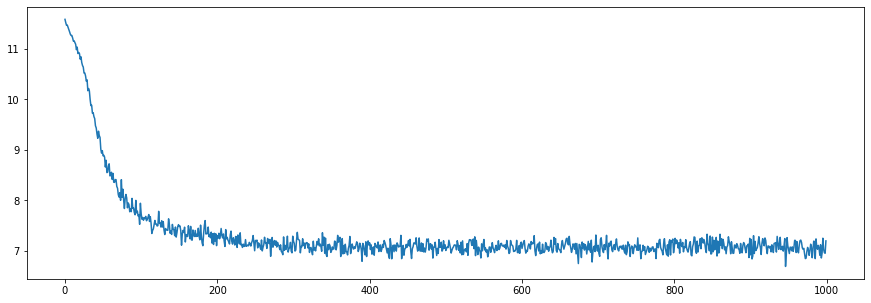

In [36]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


batch_size = 1024
n_steps = 1000
loss_history = []
for i in range(n_steps):
    ix = np.random.randint(0, len(context_pairs), batch_size)
    x_batch = X_torch[ix].to(device)
    y_batch = y_torch[ix].to(device)

    # YOUR CODE HERE
    # predict logits
    y_pred = model(x_batch)

    # YOUR CODE HERE
    # compute loss
    loss = criterion(y_pred, y_batch)

    # YOUR CODE HERE
    # clear gradients
    opt.zero_grad()

    # YOUR CODE HERE
    # compute gradients
    loss.backward()

    # YOUR CODE HERE
    # optimizer step
    opt.step()

    loss_history.append(loss.item())
    lr_scheduler.step(loss_history[-1])

    if (i + 1) % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))
        plt.plot(loss_history)
        plt.show()

In [37]:
embedding_matrix = next(model.word2emb.parameters()).detach().cpu()

In [38]:
import torch.nn.functional as F


def find_nearest(word, k=10):
    word_vector = embedding_matrix[word_to_index[word]][None, :]
    dists = F.cosine_similarity(embedding_matrix, word_vector)
    index_sorted = torch.argsort(dists)
    top_k = index_sorted[-k:]
    return [index_to_word[x] for x in top_k.numpy()]

In [39]:
find_nearest("apple", 5)

['arianespace', 'milkshake', 'cvi', 'ny', 'apple']

It might look not so promising. Remember about the upgrades to word2vec: subsampling and negative sampling.